In [12]:
# Import libraries
import pandas
import numpy
import sklearn
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from collections import Counter
from matplotlib import pyplot
from pickle import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from math import ceil
# Note, you need sklearn: 0.18.1 installed
# print('sklearn: {}'.format(sklearn.__version__))
# conda config --set ssl_verify False

In [9]:
# Some "global" parameters
seed = 7
scoring = 'recall'
test_size = 0.25
n_splits = 10
kfold = KFold(n_splits=n_splits, random_state=seed) 

In [6]:
# Load training dataset
filename = 'data\datasetFloridaPEDO.csv'
dataset = pandas.read_csv(filename)
print(dataset.shape)

(19788, 97)


In [7]:
# Perform some initial feature engineering
print(dataset.shape)

# Remove some columns which are not predictors (first 10 columns)
dataset = dataset.ix[:,10:]
print(dataset.shape)

# Remove constant variables
dataset = dataset.loc[:, dataset.apply(pandas.Series.nunique) != 1]
print(dataset.shape)

# Remove some highly correlated variables (Performed manually)
# to do...

# For now, we are using the same features which have been chosen in R, by Recursive Feature Elimination (RF)
dataset = dataset[['provider_age_time_of_service', 'amount_cost',  'amount_claim', 'total_comb1', 'member_age_time_of_service', 'zscore_comb1', 'n_claim_line_provider', 'is_radiography', 'comb4_div_comb1', 'is_exp_days_policy_exp', 'is_sealants', 'is_primary_tooth', 'is_insured_gender', 'is_posterior_tooth', 'is_member_under_10', 'comb2_div_comb1', 'is_exp_state_license_exp', 'target']]
print(dataset.shape)

(19788, 97)
(19788, 87)
(19788, 75)
(19788, 18)


In [8]:
# Prepare the dataset
array = dataset.values
X = array[:,0:16]
Y = array[:,17]

# Prepare the target variable 0 = OK | 1 = Educational | 2 = Recoupment
print(dataset.groupby('target').size())

# Change Educational to 0 and Recoupment to 1
Y = [0 if x==1 else x for x in Y]
Y = [1 if x==2 else x for x in Y]

# Print class distribution
print(Counter(Y))

target
0    12683
1     5072
2     2033
dtype: int64
Counter({0.0: 17755, 1: 2033})


In [13]:
# Split into train and test sets (Not necessary - has been done via SQL)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [52]:
# For now, we are using the same features which have been chosen in R, by Recursive Feature Elimination (RF)

# Perform an univariate feature selection 
#selector = SelectKBest(score_func=f_classif, k=16)
#fit = selector.fit(X_train, Y_train)

# Summarize scores 
#print(fit.scores_)

# Choose features
#X_train = fit.transform(X_train)

In [14]:
# prepare models 
models = [] 
models.append(('ADA', AdaBoostClassifier())) 
models.append(('GB', GradientBoostingClassifier())) 
models.append(('RF', RandomForestClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB())) 
models.append(('SVM', SVC()))

# evaluate each model in turn 
results = [] 
names = [] 

for name, model in models: 
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) 
    print(msg)

ADA: 0.263063 (0.043970)
GB: 0.394578 (0.024889)
RF: 0.572328 (0.052635)
CART: 0.599141 (0.051869)
NB: 0.438780 (0.026805)
SVM: 0.374946 (0.034335)


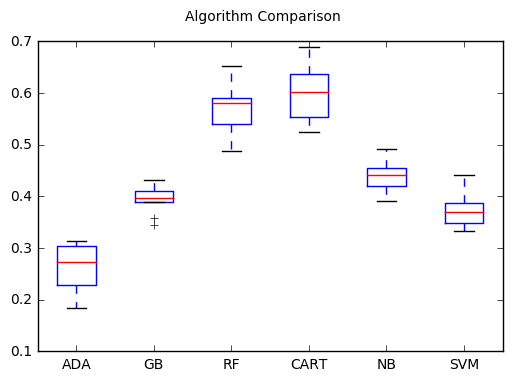

In [15]:
# Compare models
fig = pyplot.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
pyplot.boxplot(results) 
ax.set_xticklabels(names) 
pyplot.show()

In [74]:
# Create the baseline model (the best one from model comparison task)
baseline = RandomForestClassifier(random_state = seed, class_weight = {0: 0.1, 1: 0.9}, n_estimators = 400, max_features = "sqrt", criterion = "entropy") 
baseline.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.1, 1: 0.9},
            criterion='entropy', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [75]:
# Test the best model
predictions = baseline.predict(X_test)
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

[[4306  143]
 [ 199  299]]
             precision    recall  f1-score   support

        0.0       0.96      0.97      0.96      4449
        1.0       0.68      0.60      0.64       498

avg / total       0.93      0.93      0.93      4947



In [19]:
# Model tuning for CART
model = DecisionTreeClassifier(random_state = seed)

# Grid search parameters
param_grid = {
    "criterion" : ["gini", "entropy"],
    "splitter" :   ["best", "random"],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 0.0050, 0.0040, 0.0035]
}

# Execute the grid search
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
CV_model_result = CV_model.fit(X_train, Y_train)

# Print results
print("Best: %f using %s" % (CV_model_result.best_score_, CV_model_result.best_params_))

Best: 0.521500 using {'min_samples_split': 0.004, 'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}


In [ ]:
# Model tuning for ADA
DTC = DecisionTreeClassifier(random_state = seed)
model = AdaBoostClassifier(base_estimator = DTC) 

# Grid search parameters
param_grid = {
    "base_estimator__criterion" : ["gini", "entropy"],
    "base_estimator__splitter" :   ["best", "random"],
    'base_estimator__max_features': ['sqrt', 'log2'],
    'base_estimator__min_samples_split': [0.0050, 0.0040, 0.0035],
    "n_estimators": [40,50,60,70,100,150,200,500],
    "learning_rate": [0.1, 0.05, 0.02, 0.01]
}

# Execute the grid search
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
CV_model_result = CV_model.fit(X_train, Y_train)

# Print results
print("Best: %f using %s" % (CV_model_result.best_score_, CV_model_result.best_params_))

#means = CV_model_result.cv_results_['mean_test_score']
#stds = CV_model_result.cv_results_['std_test_score']
#params = CV_model_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params): 
#    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Model tuning for GB
model = GradientBoostingClassifier(random_state = seed)

# Grid search parameters
param_grid = {
    "n_estimators": [40,50,60,70,100,150,200,500],
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    
    #'max_depth': [5, 6, 7, 8],
    #'min_samples_leaf': [?],
    'min_samples_split': [0.0050, 0.0040, 0.0035],
    
    'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
    'max_features': ['sqrt', 'log2']
}

# Execute the grid search
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
CV_model_result = CV_model.fit(X_train, Y_train)

# Print results
print("Best: %f using %s" % (CV_model_result.best_score_, CV_model_result.best_params_))

In [63]:
# Model tuning for RF
model = RandomForestClassifier(random_state = seed) 

# Grid search parameters
param_grid = {
    "n_estimators": [40,50,60,70,100,150,200,500,550,600],
    "class_weight": [{0:.1, 1:.9}],
    "criterion" : ["gini", "entropy"],
    'max_features': ['sqrt', 'log2']
    #'min_samples_split': [2, 0.0050, 0.0040, 0.0035],
    #'max_depth': [5, 6, 7, 8],
    #'min_samples_leaf': [?]
    
}

# Execute the grid search
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
CV_model_result = CV_model.fit(X_train, Y_train)

# Print results
print("Best: %f using %s" % (CV_model_result.best_score_, CV_model_result.best_params_))

Best: 0.636635 using {'class_weight': {0: 0.1, 1: 0.9}, 'n_estimators': 500, 'max_features': 'sqrt', 'criterion': 'entropy'}


In [ ]:
# Model tuning for SVM
model = SVC(random_state = seed)

# Grid search parameters
param_grid = {
    "c_values" : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0],
    "kernel_values" : ['linear', 'poly', 'rbf', 'sigmoid'],
    "class_weight" : [{1: 10}]
}

# Execute the grid search
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
CV_model_result = CV_model.fit(X_train, Y_train)

# Print results
print("Best: %f using %s" % (CV_model_result.best_score_, CV_model_result.best_params_))

In [117]:
# Build the optimized model


In [ ]:
# Test the optimized model


In [74]:
# Save the model to disk 
filename = 'binary_class_model.sav' 
dump(baseline, open(filename, 'wb'))

# load the model from disk 
#loaded_model = load(open(filename, 'rb')) 
#result = loaded_model.score(X_test, Y_test) 
#print(result)# Create the final model